<a href="https://colab.research.google.com/github/ZF-TECH-NED/datascience/blob/main/zainab_task_1(14_9_2023).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Trash Classification using Dense-Net and **Keras** bold text

In [2]:
from google.colab import drive
from keras.preprocessing.image import ImageDataGenerator

In [3]:
# parameters
img_width, img_height = 224, 224  # dimensions to which the images will be resized
batch_size = 32
num_classes = 6  #categories of trash

In [4]:
project_dir = '/content/drive/MyDrive/data-science/task-1/'
trainset_dir = '/content/drive/MyDrive/data-science/task-1/training-set'
testset_dir = '/content/drive/MyDrive/data-science/task-1/test-set'

In [5]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    trainset_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size)

test_generator = test_datagen.flow_from_directory(
    testset_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle=False)

Found 2143 images belonging to 6 classes.
Found 394 images belonging to 6 classes.


In [6]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Activation, BatchNormalization
from keras import backend as K
from keras import optimizers, regularizers, Model
from keras.applications import densenet

In [7]:
# Generate model using a pretrained architecture substituting the fully connected layer
def generate_transfer_model(input_shape, num_classes):

    # imports the pretrained model and discards the fc layer
    base_model = densenet.DenseNet121(
        include_top=False,
        weights='imagenet',
        input_tensor=None,
        input_shape=input_shape,
        pooling='max') #using max global pooling, no flatten required

    # train only the top layers, i.e. freeze all convolutional layers
#     for layer in base_model.layers:
#        layer.trainable = False

    # unfreeze last convolutional block
#     train_last_conv_layer = True
#     if train_last_conv_layer:
#         n_layers_unfreeze = (7*16+3+7*24+4) #last two conv
#         for layer in base_model.layers[-n_layers_unfreeze:]:
#             layer.trainable = True

    # add fc layers
    x = base_model.output
    #x = Dense(256, activation="relu")(x)
    x = Dense(256, activation="elu", kernel_regularizer=regularizers.l2(0.1))(x)
    x = Dropout(0.6)(x)
    x = BatchNormalization()(x)
    predictions = Dense(num_classes, activation="softmax")(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    # compile model using accuracy to measure model performance and adam optimizer
    #optimizer = optimizers.Adam(lr=0.0001)
    optimizer = optimizers.SGD(learning_rate=0.0001, momentum=0.9, nesterov=True)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [13]:
from keras import backend as K

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

print("generating model")
model = generate_transfer_model(input_shape, num_classes)

generating model


started fit


<ipython-input-20-feec427163bb>:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
10/10 [==============================] - 10s 923ms/step - loss: 31.5990 - accuracy: 0.7750 - val_loss: 31.5414 - val_accuracy: 0.7766
Epoch 2/20
10/10 [==============================] - 11s 1s/step - loss: 31.4556 - accuracy: 0.7688 - val_loss: 31.4053 - val_accuracy: 0.7690
Epoch 3/20
10/10 [==============================] - 12s 1s/step - loss: 31.3575 - accuracy: 0.7594 - val_loss: 31.2631 - val_accuracy: 0.7741
Epoch 4/20
10/10 [==============================] - 9s 848ms/step - loss: 31.1843 - accuracy: 0.7594 - val_loss: 31.1137 - val_accuracy: 0.7868
Epoch 5/20
10/10 [==============================] - 11s 1s/step - loss: 31.0657 - accuracy: 0.7875 - val_loss: 31.0119 - val_accuracy: 0.7868
Epoch 6/20
10/10 [==============================] - 10s 1s/step - loss: 30.9689 - accuracy: 0.7680 - val_loss: 31.0008 - val_accuracy: 0.7411
Epoch 7/20
10/10 [==============================] - 9s 881ms/step - loss: 30.8411 - accuracy: 0.7625 - val_loss: 30.9591 - val_accuracy: 0.7030

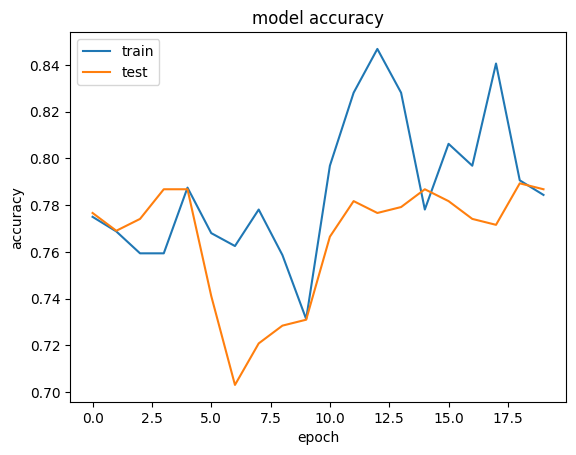

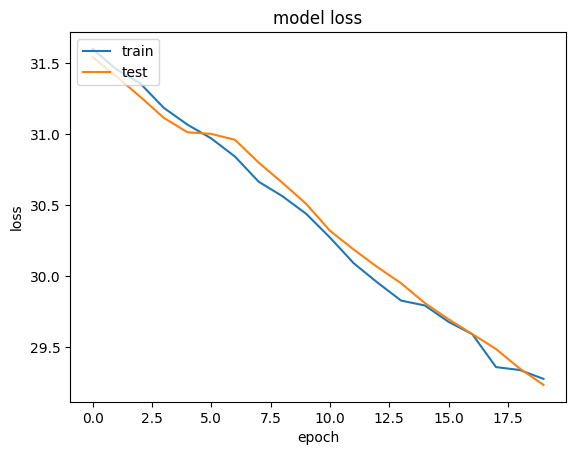

In [20]:
import matplotlib.pyplot as plt
import numpy as np

n_epochs = 20
training_period = 2
load_weights_file = project_dir+'weights_save_{}.h5'.format(training_period)
save_weights_file = project_dir+'weights_save_{}.h5'.format(training_period+1)

def load_weights():
    print("loading weights")
    model.load_weights(load_weights_file)

def fit(n_epochs): #steps_per_epoch=len(train_generator) ,  validation_steps=len(test_generator)
    print("started fit")
    history = model.fit_generator(
        train_generator,
        10,
        epochs=n_epochs,
        validation_data=test_generator)

    print("saving")
    model.save_weights(save_weights_file)

    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


def print_layers():
    for layer in model.layers:
        print(layer.name)
        print("trainable: "+str(layer.trainable))
        print("input_shape: " + str(layer.input_shape))
        print("output_shape: " + str(layer.output_shape))
        print("_____________")



#load_weights()
fit(n_epochs)
#print_layers()

In [23]:
#load_weights()
print_layers()

input_2
trainable: True
input_shape: [(None, 224, 224, 3)]
output_shape: [(None, 224, 224, 3)]
_____________
zero_padding2d_2
trainable: True
input_shape: (None, 224, 224, 3)
output_shape: (None, 230, 230, 3)
_____________
conv1/conv
trainable: True
input_shape: (None, 230, 230, 3)
output_shape: (None, 112, 112, 64)
_____________
conv1/bn
trainable: True
input_shape: (None, 112, 112, 64)
output_shape: (None, 112, 112, 64)
_____________
conv1/relu
trainable: True
input_shape: (None, 112, 112, 64)
output_shape: (None, 112, 112, 64)
_____________
zero_padding2d_3
trainable: True
input_shape: (None, 112, 112, 64)
output_shape: (None, 114, 114, 64)
_____________
pool1
trainable: True
input_shape: (None, 114, 114, 64)
output_shape: (None, 56, 56, 64)
_____________
conv2_block1_0_bn
trainable: True
input_shape: (None, 56, 56, 64)
output_shape: (None, 56, 56, 64)
_____________
conv2_block1_0_relu
trainable: True
input_shape: (None, 56, 56, 64)
output_shape: (None, 56, 56, 64)
_____________
con

In [39]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
import pandas as pd

def print_classification_report():
    # Confution Matrix and Classification Report
    Y_pred = model.predict_generator(test_generator, len(test_generator))
    y_pred = np.argmax(Y_pred, axis=1)  # it return index number of maximum value

    print('Classification Report')
    target_names = list(test_generator.class_indices.keys())
    print(classification_report(test_generator.classes, y_pred, target_names=target_names))

    print('Confusion Matrix')
    conf_mat = confusion_matrix(test_generator.classes, y_pred)
    df_cm = pd.DataFrame(conf_mat, index = target_names, columns = target_names)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)



<ipython-input-31-30f13cf52a39>:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_generator, len(test_generator))


Classification Report
              precision    recall  f1-score   support

   cardboard       0.85      0.90      0.87        61
       glass       0.86      0.85      0.85        79
       metal       0.81      0.90      0.85        69
       paper       0.71      0.92      0.80        90
     plastic       0.77      0.56      0.65        73
       trash       0.50      0.09      0.15        22

    accuracy                           0.79       394
   macro avg       0.75      0.70      0.70       394
weighted avg       0.78      0.79      0.77       394

Confusion Matrix


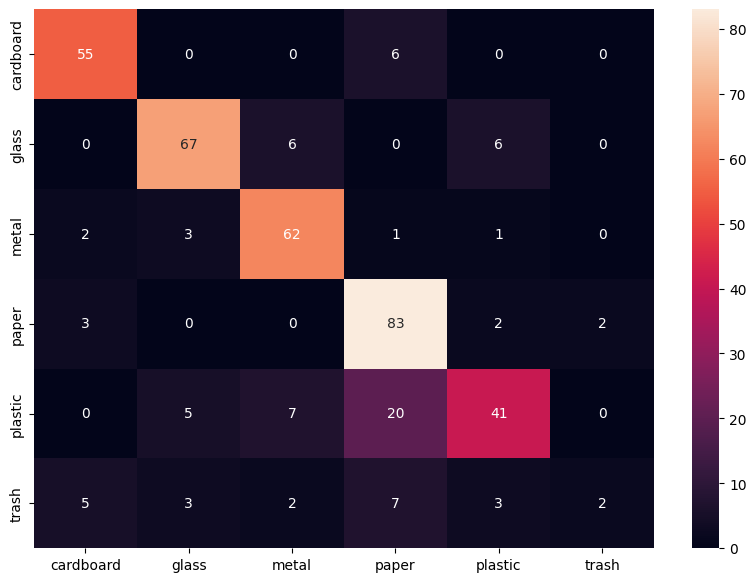

In [32]:
print_classification_report()

In [46]:
Y_pred = model.predict_generator(test_generator, len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

<ipython-input-46-e581ec60dabb>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_generator, len(test_generator))


In [47]:
print(Y_pred)
print(y_pred)


[[9.45233405e-01 9.56083124e-04 1.38769543e-03 4.83704265e-03
  1.69327715e-03 4.58925068e-02]
 [9.72692013e-01 8.62838293e-04 9.92725953e-04 7.04705762e-03
  2.69299420e-03 1.57123748e-02]
 [9.91231263e-01 1.68402126e-04 6.53312949e-04 3.33689456e-03
  8.89389717e-04 3.72082694e-03]
 ...
 [7.24635363e-01 1.32380344e-03 6.66034082e-03 6.07566983e-02
  3.57111124e-03 2.03052610e-01]
 [6.74261451e-01 3.12524452e-03 7.29766255e-03 5.95582612e-02
  2.79559032e-03 2.52961785e-01]
 [7.69249350e-02 5.14435023e-03 6.69771153e-03 8.01203072e-01
  1.28690898e-03 1.08743005e-01]]
[0 0 0 3 0 0 0 0 0 0 3 3 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 3 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 4 1 1 1 1
 4 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 2 4 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 2 1 4 1 2 4 1 1 1 1 1 1 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2
 2 1 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 0 0 2 2 2 2 